# First Test for Volatility Based VaR

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from itertools import product

# Import functions
import volatility_var as vv
import backtesting as bt
import plots 
import expected_shortfall as ES

### Data

In [2]:
# Download data
sp500_data = yf.download("DJA", start="2007-01-01", end="2021-01-01")
sp500_data["Log Returns"] = np.log(sp500_data["Close"] / sp500_data["Close"].shift(1))
returns = sp500_data["Log Returns"].dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DJA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


### Garch based VaR on S&P 500

In [3]:
# Set parameters
confidence_level = 0.99 # <----- Can choose 0.95 etc

In [4]:
# Apply GARCH volatility model
garch_output, next_day_var = vv.var_garch(returns, confidence_level, vol_model="GJR")

print(f"Next-day GARCH VaR estimate (abs): {100 * next_day_var:.2f}%")

# Backtest full period
violations, rate = bt.backtest_var(garch_output, confidence_level)
print(f"Full Period — Violations: {violations}, Rate: {rate:.2f}%")

# Backtest a subset
viol_subset, rate_subset = bt.backtest_var(garch_output, confidence_level, "2019-11-01", "2020-11-30")
print(f"Subset — Violations: {viol_subset}, Rate: {rate_subset:.2f}%")

# Compute ES for the whole period
garch_output = ES.compute_expected_shortfall_volatility(garch_output, confidence_level)

ValueError: first_obs and last_obs produce in an empty array.


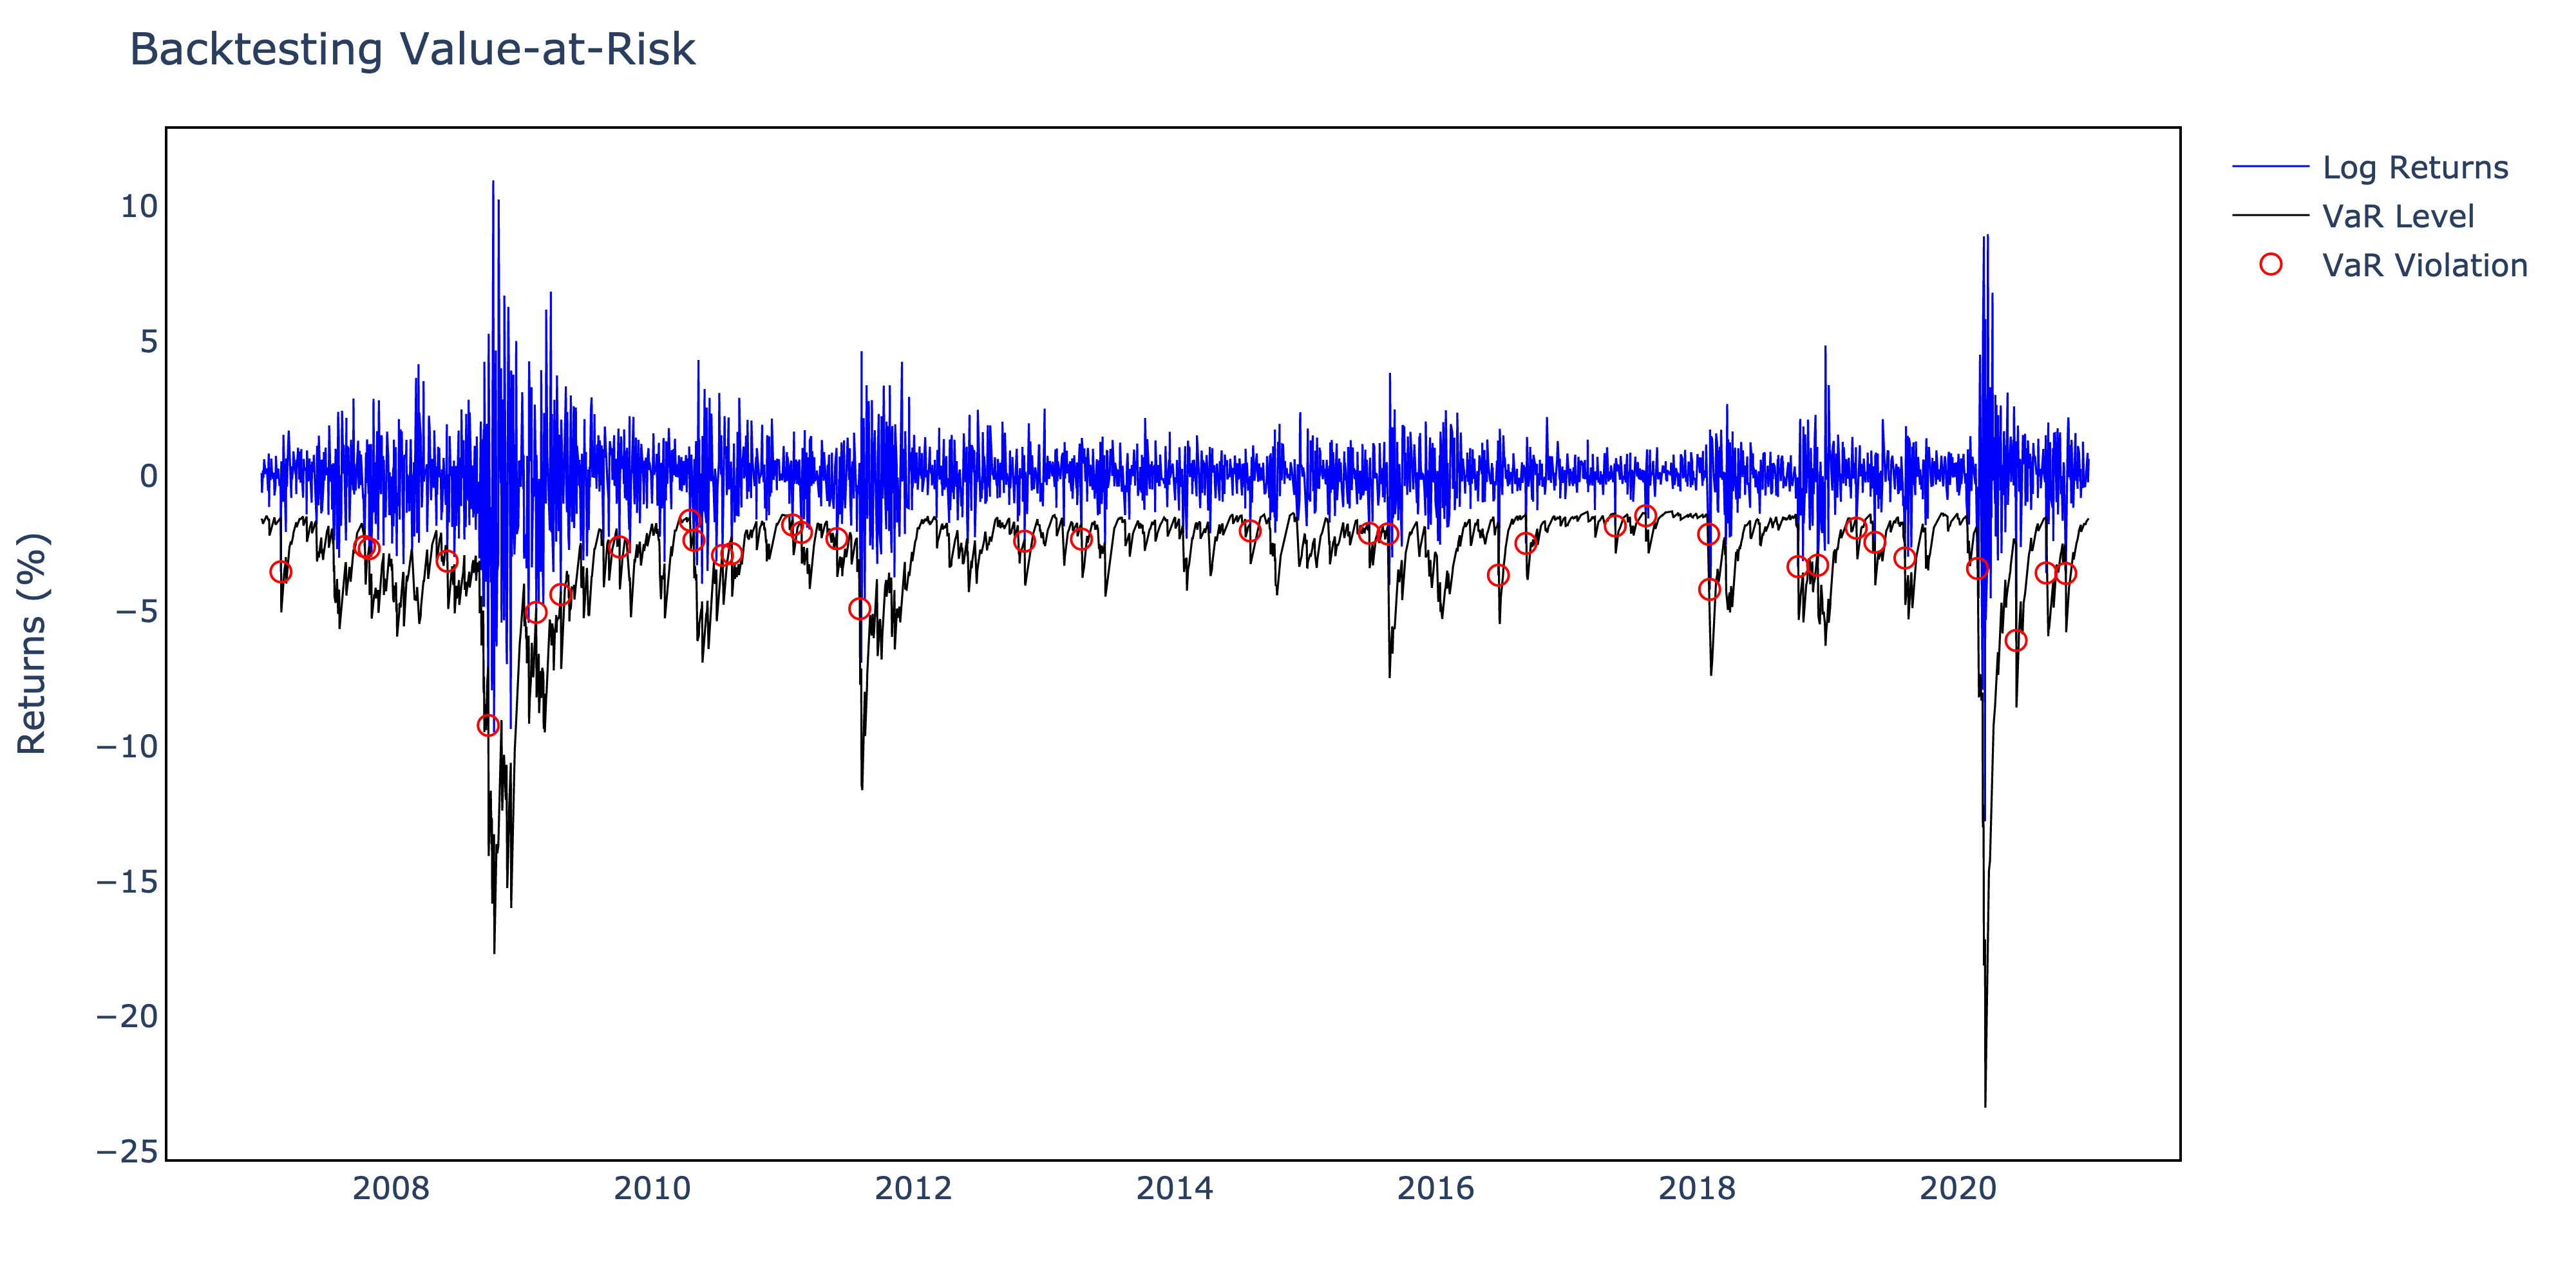


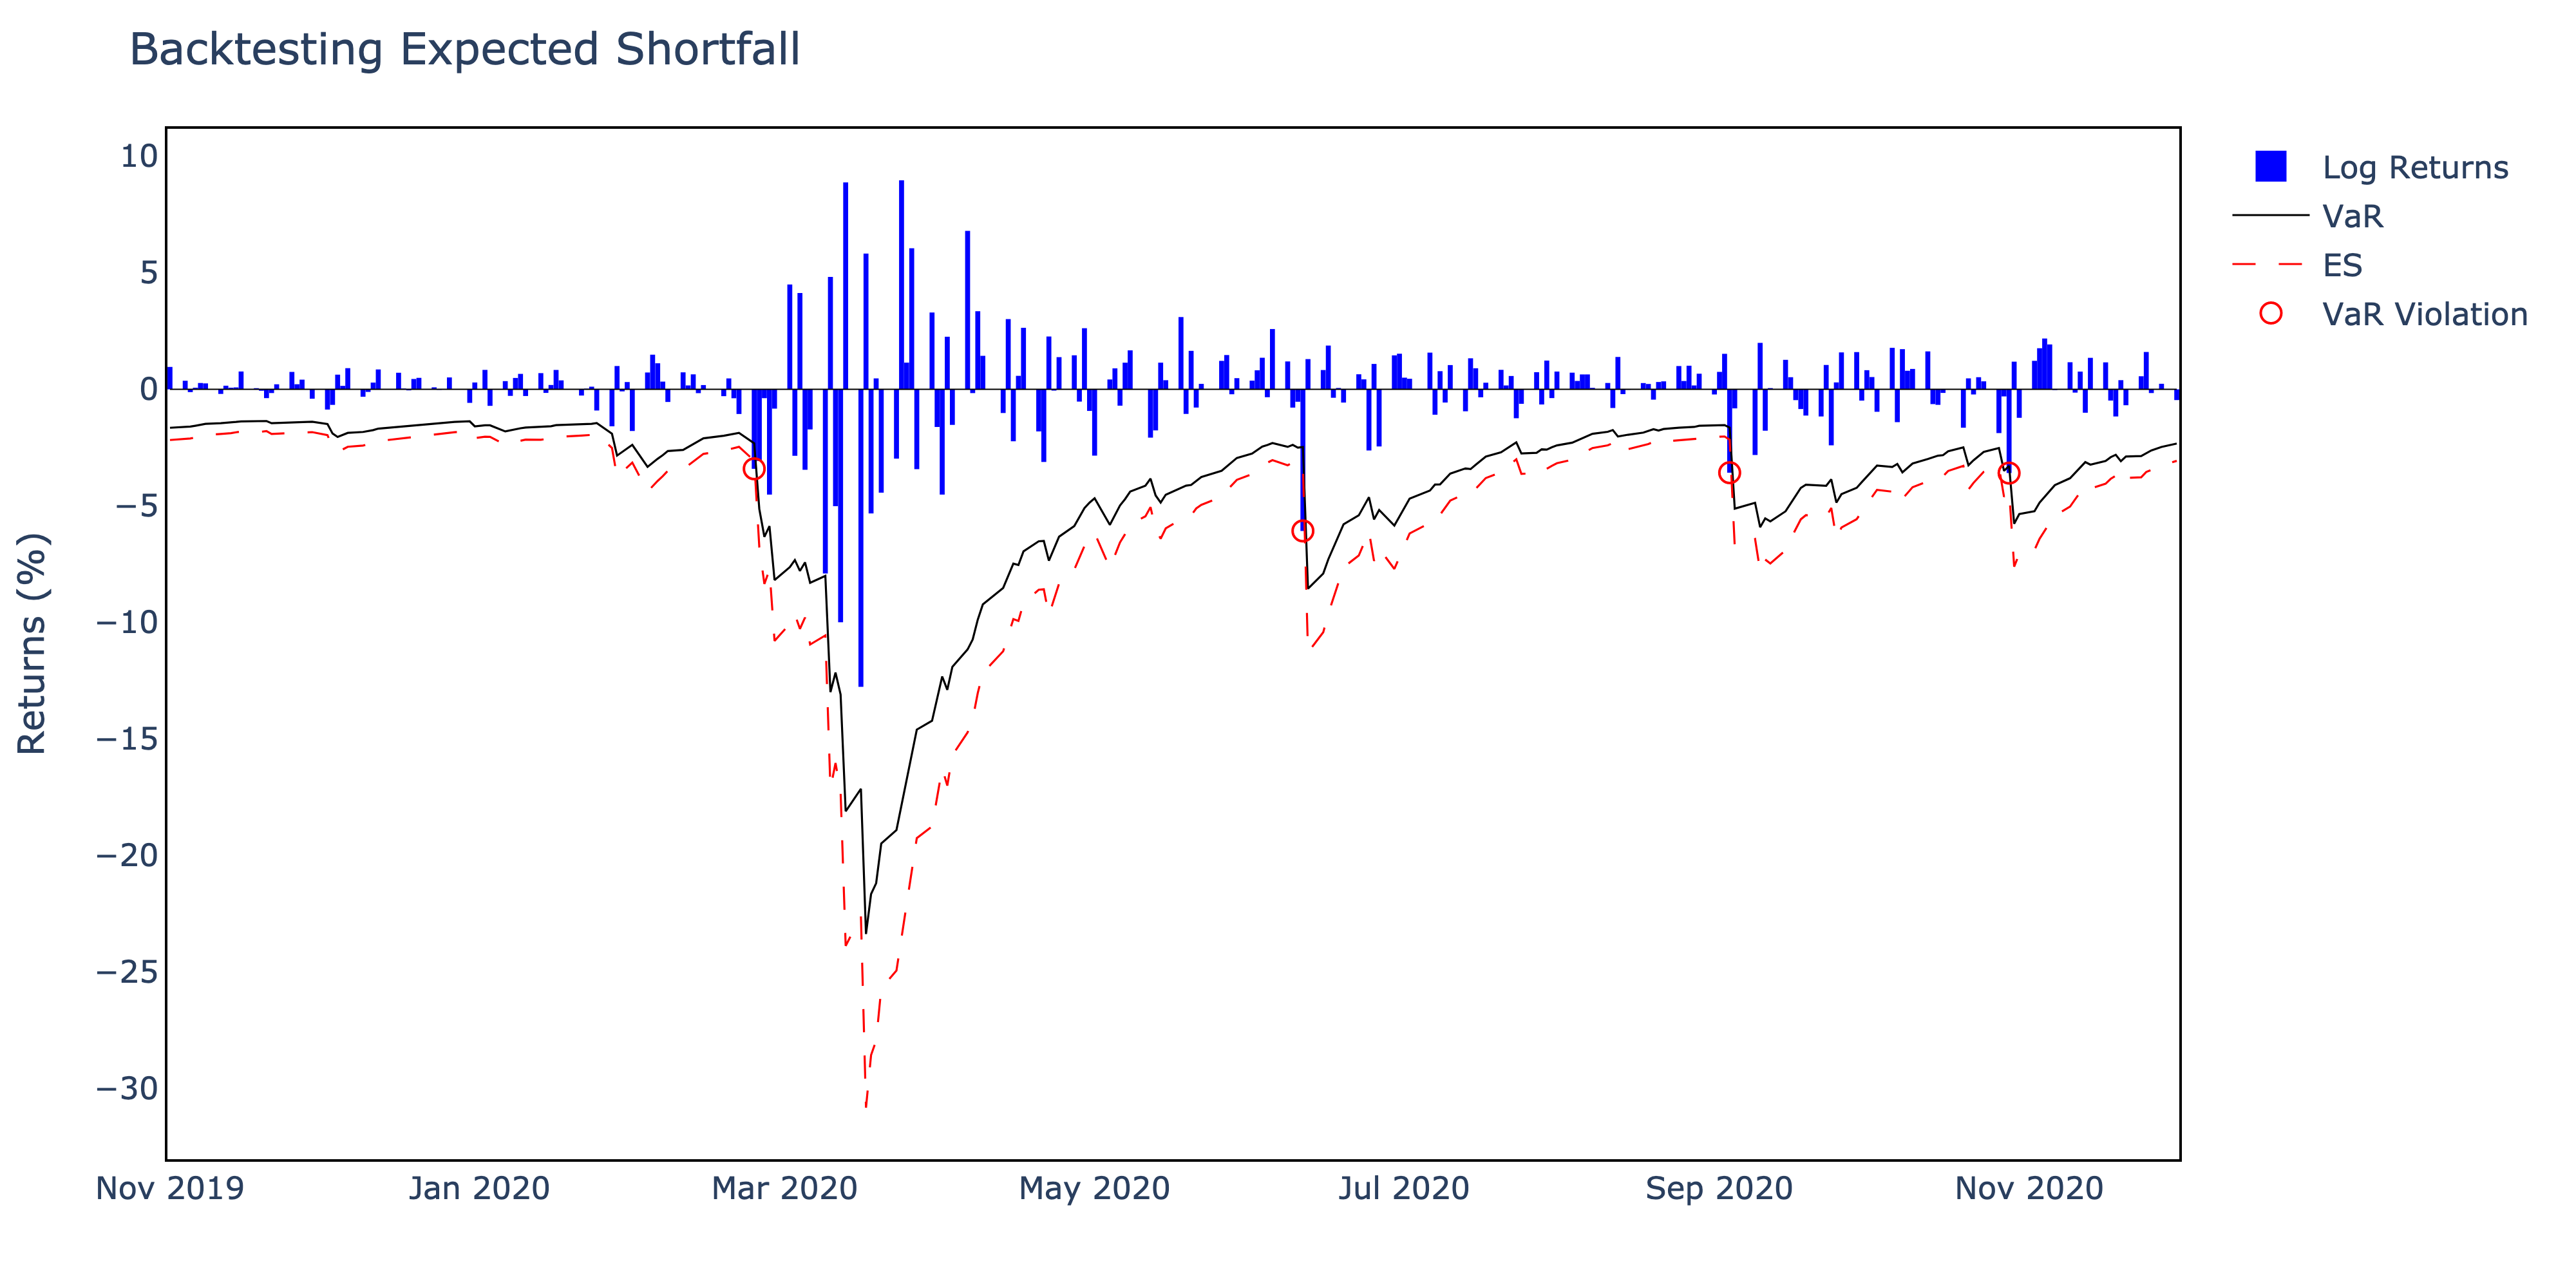

In [35]:
# Plot interactive VaR
fig_var = plots.plot_var(garch_output, interactive=False)

# Plot interactive ES for a subset
fig_es = plots.plot_es(garch_output, subset=("2019-11-01", "2020-11-30"), interactive=False)

# Plot interactive volatility for a subset
fig_vol = plots.plot_volatility(garch_output["Volatility"], subset=("2019-11-01", "2020-11-30"), interactive=True)

In [36]:
print(next_day_var)

0.015367999641435799


In [37]:
garch_output.head()

,Returns,Volatility,Innovations,VaR,VaR Violation,ES
Date,,,,,,
2007-01-04,0.001228,0.005789,0.212041,0.016222,False,0.021395
2007-01-05,-0.006103,0.005602,-1.089490,0.015697,False,0.020703
2007-01-08,0.002218,0.006262,0.354156,0.017548,False,0.023144
2007-01-09,-0.000517,0.006023,-0.085808,0.016877,False,0.022258
2007-01-10,0.001938,0.005820,0.333069,0.016309,False,0.021509


### Arch


In [38]:
# Apply ARCH volatility model
arch_output, next_day_var = vv.var_arch(returns, confidence_level)

print(f"Next-day ARCH VaR estimate (abs): {100 * next_day_var:.2f}%")

# Backtest full period
violations, rate = bt.backtest_var(arch_output, confidence_level)
print(f"Full Period — Violations: {violations}, Rate: {rate:.2f}%")

# Compute ES for the whole period
arch_output = ES.compute_expected_shortfall_volatility(arch_output, confidence_level)

Next-day ARCH VaR estimate (abs): 3.10%
Full Period — Violations: 36, Rate: 1.02%


### Garch Forecasts

Try the error when trying to scale the variance by wealth. Also try wealth scaling...

In [ ]:
# Configuration grid
steps_list = [1, 5, 10]
cumulative_list = [False, True]

print("GARCH(1,1) VaR Forecasts (Normal Only)\n" + "-" * 40)

for steps_ahead, cumulative in product(steps_list, cumulative_list):
    try:
        var_value = vv.garch_forecast(
            returns=returns,
            steps_ahead=steps_ahead,
            cumulative=cumulative,
            compute_var=True,
            confidence_level=0.99
        )

        label = f"VaR | {steps_ahead}-day | {'CUM' if cumulative else 'Single'}"
        print(f"{label:<35}: {var_value * 100:.4f}%")  # Convert to percent

    except Exception as e:
        print(f"{label:<35}: ERROR → {e}")


GARCH(1,1) VaR Forecasts
------------------------------
VaR | 1-day | Single | NORMAL                : 1.3780%
VaR | 1-day | Single | T                     : 1.6075%
VaR | 1-day | Single | GED                   : 1.6010%
VaR | 1-day | CUM | NORMAL                   : 1.3217%
VaR | 1-day | CUM | T                        : 1.5419%
VaR | 1-day | CUM | GED                      : 1.5357%
VaR | 5-day | Single | NORMAL                : 1.5736%
VaR | 5-day | Single | T                     : 1.8357%
VaR | 5-day | Single | GED                   : 1.8283%
VaR | 5-day | CUM | NORMAL                   : 3.1973%
VaR | 5-day | CUM | T                        : 3.7298%
VaR | 5-day | CUM | GED                      : 3.7149%
VaR | 10-day | Single | NORMAL               : 1.7707%
VaR | 10-day | Single | T                    : 2.0656%
VaR | 10-day | Single | GED                  : 2.0574%
VaR | 10-day | CUM | NORMAL                  : 4.8938%
VaR | 10-day | CUM | T                       : 5.7089%
VaR | 10-

### MA based VaR on the same data

In [40]:
# Apply MA volatility model
ma_output, next_day_var = vv.var_moving_average(returns, confidence_level)

print(f"Next-day MA VaR estimate (abs): {100 * next_day_var:.2f}%")

# Backtest full period
violations, rate = bt.backtest_var(ma_output, confidence_level)
print(f"Full Period — Violations: {violations}, Rate: {rate:.2f}%")

# Backtest a subset
viol_subset, rate_subset = bt.backtest_var(ma_output, confidence_level, "2019-11-01", "2020-11-30")
print(f"Subset — Violations: {viol_subset}, Rate: {rate_subset:.2f}%")

# Compute ES for the whole period
ma_output = ES.compute_expected_shortfall_volatility(ma_output, confidence_level)

Next-day MA VaR estimate (abs): 1.40%
Full Period — Violations: 36, Rate: 1.03%
Subset — Violations: 6, Rate: 2.21%


### Testing Wealth as Input (GARCH, GARCH forecasting)

In [41]:
# Apply GARCH volatility model
garch_output_wealth, next_day_var = vv.var_garch(returns, confidence_level, vol_model="GJR", wealth=1000000)

print(f"Next-day GARCH VaR estimate (abs): { next_day_var:.2f}")

garch_output_wealth.head()

Next-day GARCH VaR estimate (abs): 15368.00


,Returns,Volatility,Innovations,VaR,VaR Violation,VaR_monetary
Date,,,,,,
2007-01-04,0.001228,0.005789,0.212041,0.016222,False,16221.981485
2007-01-05,-0.006103,0.005602,-1.089490,0.015697,False,15697.212482
2007-01-08,0.002218,0.006262,0.354156,0.017548,False,17548.091887
2007-01-09,-0.000517,0.006023,-0.085808,0.016877,False,16876.910415
2007-01-10,0.001938,0.005820,0.333069,0.016309,False,16308.578014


In [43]:
# Compute ES for the whole period
garch_output_wealth_es = ES.compute_expected_shortfall_volatility(garch_output, confidence_level, wealth=1000000)

garch_output_wealth_es.head()   

,Returns,Volatility,Innovations,VaR,VaR Violation,ES,ES_monetary
Date,,,,,,,
2007-01-04,0.001228,0.005789,0.212041,0.016222,False,0.021395,21394.601752
2007-01-05,-0.006103,0.005602,-1.089490,0.015697,False,0.020703,20702.502341
2007-01-08,0.002218,0.006262,0.354156,0.017548,False,0.023144,23143.562195
2007-01-09,-0.000517,0.006023,-0.085808,0.016877,False,0.022258,22258.364520
2007-01-10,0.001938,0.005820,0.333069,0.016309,False,0.021509,21508.810873


### Appendix

#### 1. GARCH(p, q) VaR  
Standard GARCH captures volatility clustering using past squared shocks and variances.

$$
r_t = \mu + \varepsilon_t, \quad \varepsilon_t = \sigma_t z_t
$$

$$
\sigma_t^2 = \omega + \sum_{i=1}^q \alpha_i \varepsilon_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 2. EGARCH(p, q) VaR  
EGARCH models log-volatility and captures asymmetry in the volatility response.

$$
\log(\sigma_t^2) = \omega + \sum_{i=1}^q \beta_i \log(\sigma_{t-i}^2) + \sum_{j=1}^p \alpha_j \left( \frac{|\varepsilon_{t-j}|}{\sigma_{t-j}} - \mathbb{E}\left[ \frac{|\varepsilon_{t-j}|}{\sigma_{t-j}} \right] \right) + \gamma_j \frac{\varepsilon_{t-j}}{\sigma_{t-j}}
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 3. GJR-GARCH(p, q) VaR  
GJR-GARCH adds an indicator term to account for the leverage effect of negative shocks.

$$
\sigma_t^2 = \omega + \sum_{i=1}^q \alpha_i \varepsilon_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2 + \sum_{i=1}^q \gamma_i \varepsilon_{t-i}^2 \cdot \mathbb{I}_{\{\varepsilon_{t-i}<0\}}
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 4. APARCH(p, q) VaR  
APARCH generalizes GARCH with power terms and asymmetry.

$$
\sigma_t^\delta = \omega + \sum_{i=1}^q \alpha_i \left( |\varepsilon_{t-i}| - \gamma_i \varepsilon_{t-i} \right)^\delta + \sum_{j=1}^p \beta_j \sigma_{t-j}^\delta
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 5. ARCH(p) VaR  
ARCH models volatility using only past squared residuals.

$$
\sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i \varepsilon_{t-i}^2
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 6. EWMA VaR  
EWMA assigns exponentially decaying weights to past squared returns.

$$
\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1 - \lambda) r_{t-1}^2
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 7. MA VaR  
Moving Average volatility is estimated using a rolling window of past squared returns.

$$
\sigma_t = \sqrt{ \frac{1}{n} \sum_{i=1}^n r_{t-i}^2 }
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

#### 8. Expected Shortfall (ES)  
Expected Shortfall estimates the conditional expectation of loss beyond the VaR.

$$
\text{ES}_t = -\hat{\sigma}_t \cdot \mathbb{E}[z_t \mid z_t < z_\alpha]
$$

---

#### 9. GARCH(1,1) Variance Forecast – Analytical  

Forecast for single-step variance $T$ steps ahead:

$$
\mathbb{E}[\sigma_{t+T}^2] = \text{VL} + (\alpha + \beta)^T \cdot (\sigma_t^2 - \text{VL})
$$

Forecast for cumulative variance over $T$ days:

$$
\mathbb{E}[\sigma_{t,T}^2] =
\text{VL} \cdot \left( T - 1 - \frac{(\alpha + \beta)(1 - (\alpha + \beta)^{T - 1})}{1 - (\alpha + \beta)} \right)
+ \sigma_t^2 \cdot \frac{1 - (\alpha + \beta)^T}{1 - (\alpha + \beta)}
$$

Where:

- $\text{VL} = \dfrac{\omega}{1 - \alpha - \beta}$ is the long-run variance  
- $\sigma_t^2$ is the last fitted conditional variance  


#### 10. GARCH(1,1) VaR Forecast – Analytical  

Once variance is forecasted, the VaR over the horizon $T$ is:

$$
\text{VaR}_{t,T} = - z_\alpha \cdot \sqrt{\mathbb{E}[\sigma_{t,T}^2]}
$$

Where $z_\alpha$ is the quantile of the fitted standardized innovation distribution:

- Normal: $z_\alpha = \Phi^{-1}(1 - \alpha)$  
- Student-t / GED: fitted on standardized residuals
